In [1]:
from LNN import *

from scipy.stats import lognorm

import h5py 

# matplotlib settings
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'gray',
    'axes.grid': False,
    'savefig.dpi': 150,  # to adjust notebook inline plot size
    'axes.labelsize': 8, # fontsize for x and y labels (was 10)
    'axes.titlesize': 8,
    'font.size': 8, # was 10
    'legend.fontsize': 6, # was 10
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'text.usetex': True,
    'figure.figsize': [3.39, 2.10],
    'font.family': 'serif',
}
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update(params)
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

colors = ['#377eb8', '#ff7f00', '#4daf4a', 
          '#f781bf', '#a65628', '#984ea3', 
          '#999999', '#e41a1c', '#dede00']

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def colorbar(mappable):
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    return fig.colorbar(mappable, cax=cax)

# Functions

In [3]:
def struct_weight_plot_nonlinear_N(N_max, ks, v=None, s=1., typ=1, colors=colors,
                           sigmaM=1., sigmaC=1., ax=None, linestyle='-'):
    # create plot
    if ax is None:
        fig = plt.figure(figsize = (10, 8))
        ax = fig.add_subplot(111)
    # iterate over scales
    for k_idx, k in enumerate(ks):
        Ns = np.arange(k, N_max, k)
        data = np.zeros(Ns.shape)
        for N_idx, N in enumerate(Ns):
            if typ==1:
                w=LNN.struct_weight_maker(N, k)
            else:
                w=LNN.struct_weight_maker(N, N/k)
            lnn = LNN(v=np.ones(N), w=w, 
                      sigmaM=sigmaM, sigmaC=sigmaC, nonlinearity='squared')
            data[N_idx] = lnn.FI_squared_nonlin(s)
        if typ==1:
            ax.plot(Ns, data, label=r'$k=%s$' %k, linewidth=4, color=colors[-k_idx], linestyle=linestyle)
        else:
            ax.plot(Ns, data, label=r'$k=N/%s$' %k, linewidth=4, color=colors[k_idx], linestyle=linestyle)
    ax.set_facecolor('white')
    ax.set_xlabel(r'$N$', fontsize = 30)
    ax.tick_params(labelsize=20)
    lgd = ax.legend(loc=2, ncol=2, facecolor='white', prop={'size' : 15})
    lgd.get_frame().set_edgecolor('k')
    for spine in ax.spines.values():
        spine.set_edgecolor('k')
    return ax

In [4]:
def struct_weight_plot_nonlinear_k(Ns, ks, v=None, s=1., colors=colors,
                           sigmaM=1., sigmaC=1., ax=None, linestyle='-'):
    # create plot
    if ax is None:
        fig = plt.figure(figsize = (10, 8))
        ax = fig.add_subplot(111)
    data = np.zeros((Ns.size, ks.size))
    # iterate over scales
    for N_idx, N in enumerate(Ns):
        for k_idx, k in enumerate(ks):
            w=LNN.struct_weight_maker(N, k)
            lnn = LNN(v=np.ones(N), w=w, 
                      sigmaM=sigmaM, sigmaC=sigmaC, nonlinearity='squared')
            data[N_idx, k_idx] = lnn.FI_squared_nonlin(s)
        ax.plot(ks, data[N_idx, :], label=r'$N=%s$' %N, linewidth=4, color=colors[N_idx], linestyle=linestyle)
    ax.set_facecolor('white')
    ax.set_xlabel(r'$k_{\mathbf{w}}$', fontsize = 30)
    ax.tick_params(labelsize=20)
    lgd = ax.legend(loc=3, bbox_to_anchor=(0., 1.02, 1., .102),
          fancybox=True, ncol=4, mode="expand", borderaxespad=0., prop={'size' : 15})
    #lgd = ax.legend(ncol=4, facecolor='white', prop={'size' : 13})
    lgd.get_frame().set_edgecolor('k')
    for spine in ax.spines.values():
        spine.set_edgecolor('k')
    return ax

In [5]:
def plot_fisher_nonlinear_2d(N, ratios, ks, v=None, s=1., typ=1, colors=colors,
                            ax=None):
    # create plot
    if ax is None:
        fig = plt.figure(figsize = (10, 8))
        ax = fig.add_subplot(111)
    if v is None:
        v = np.ones(N)
    fishers = np.zeros((ratios.size, ks.size))
    for ratio_idx, ratio in enumerate(ratios):
        sigmaC = 1
        sigmaM = ratio * sigmaC
        for k_idx, k in enumerate(ks):
            if typ==1:
                w=LNN.struct_weight_maker(N, k)
            else:
                w=LNN.struct_weight_maker(N, N/k)    
            lnn = LNN(v=np.ones(N), w=w, 
                      sigmaM=sigmaM, sigmaC=sigmaC, nonlinearity='squared')
            fishers[ratio_idx, k_idx] = lnn.FI_squared_nonlin(s)
        fishers[ratio_idx, :] = fishers[ratio_idx, :]/np.max(fishers[ratio_idx, :])
    ax.grid(False)
    img = ax.imshow(fishers.T, interpolation='spline36')
    ax.tick_params(labelsize=20)
    return img

In [6]:
def plot_coefficients(filename, ax=None):
    # create plot
    labels = [1, 2, 3]
    if ax is None:
        fig = plt.figure(figsize = (10, 8))
        ax = fig.add_subplot(111)
    coef_file = h5py.File(filename, 'r')
    sigmaM_vals = list(coef_file)
    ks = np.arange(1, 26)
    for idx, sigmaM in enumerate(sigmaM_vals):
        coefs = coef_file[sigmaM]
        ax.plot(ks, coefs, linewidth=4, label=r'$\sigma_M=%s$' %labels[idx])
        lgd = ax.legend(loc=3, bbox_to_anchor=(0., 1.02, 1., .102),
          fancybox=True, ncol=3, mode="expand", borderaxespad=0., prop={'size' : 15})
    lgd.get_frame().set_edgecolor('k')

# Plot Figure 3

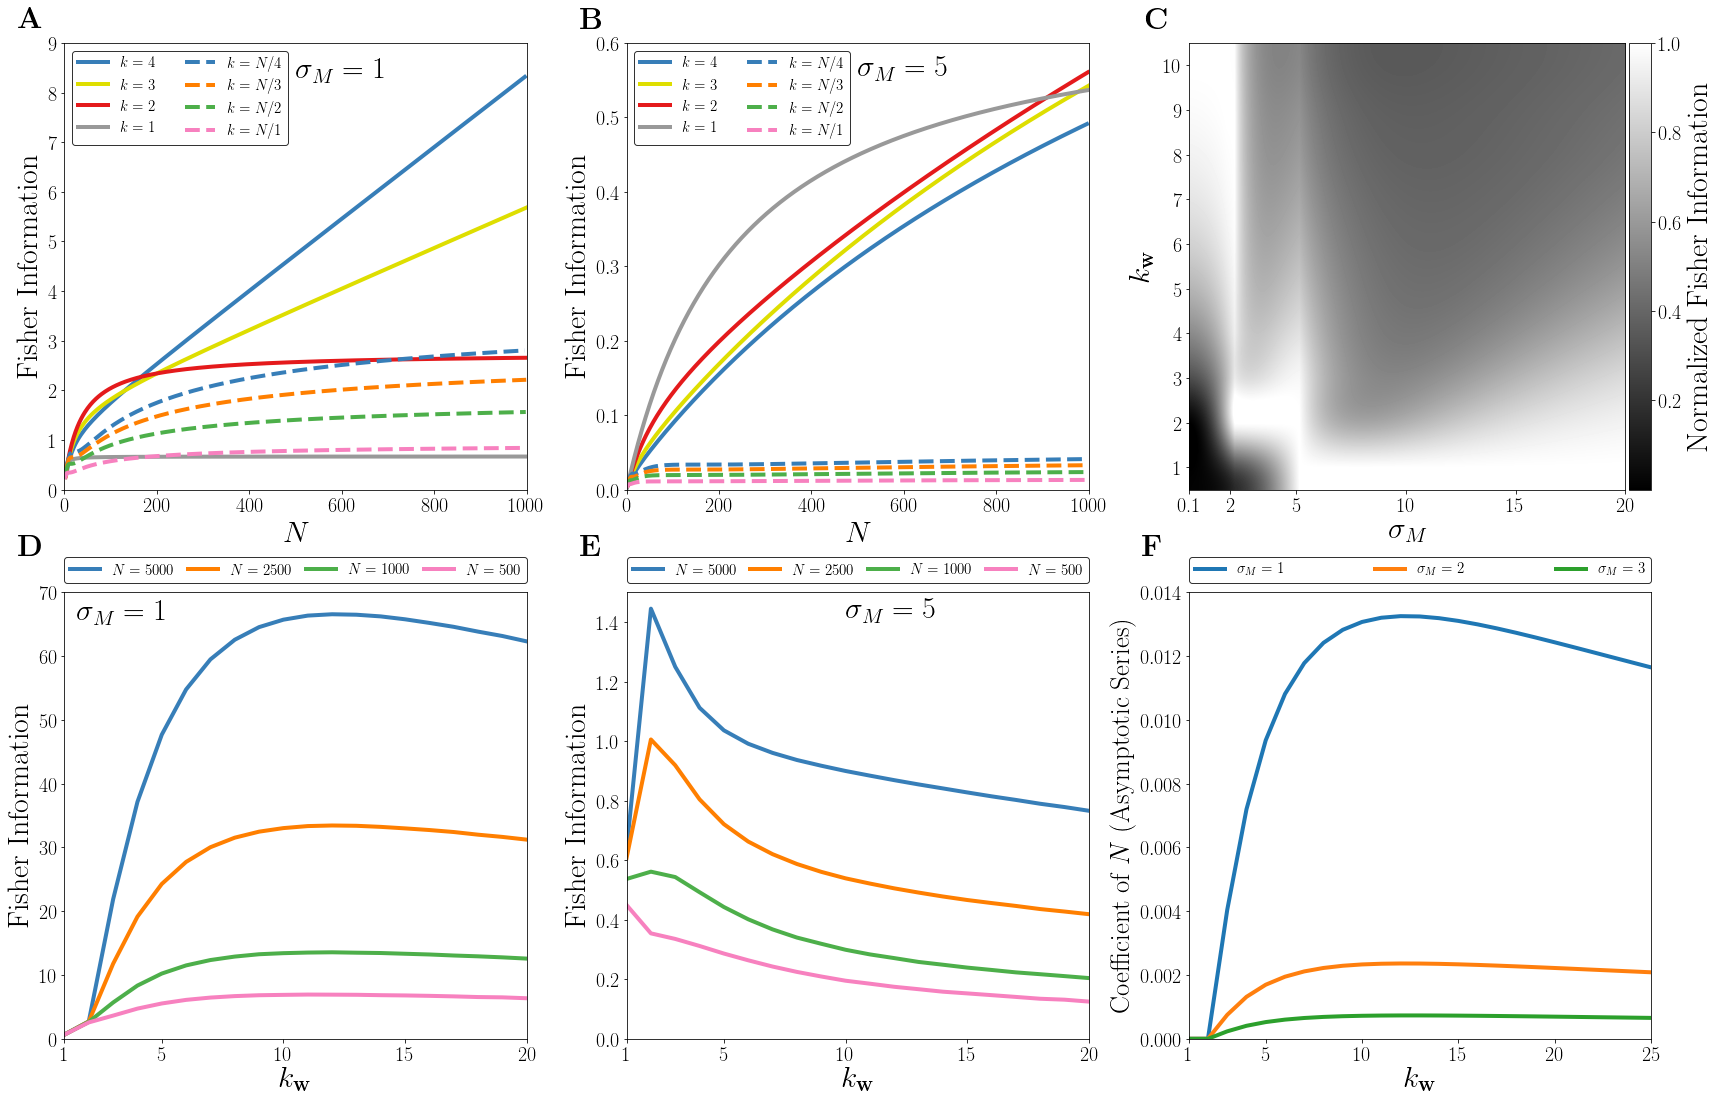

In [13]:
fig, axes = plt.subplots(2, 3, figsize=(24,16))

struct_weight_plot_nonlinear_N(1000, [4,3,2,1], typ=1, ax=axes[0,0], sigmaM=1.)
struct_weight_plot_nonlinear_N(1000, [4,3,2,1], typ=2, ax=axes[0,0], linestyle='--', sigmaM=1.)
axes[0,0].set_xlim([0, 1000])
axes[0,0].set_ylim([0, 9])
axes[0,0].set_ylabel('Fisher Information', fontsize=30)
axes[0, 0].text(x=-0.1, y=1.05, s=r'\textbf{A}', fontsize=30, verticalalignment='center', transform=axes[0, 0].transAxes)
axes[0,0].text(500, 8.2, s=r'$\sigma_M=1$', fontsize=30)

struct_weight_plot_nonlinear_N(1000, [4,3,2,1], typ=1, ax=axes[0,1], sigmaM=5.)
struct_weight_plot_nonlinear_N(1000, [4,3,2,1], typ=2, ax=axes[0,1], linestyle='--', sigmaM=5.)
axes[0,1].set_xlim([0, 1000])
axes[0,1].set_ylim([0, 0.6])
axes[0,1].set_ylabel('Fisher Information', fontsize=30)
axes[0,1].text(x=-0.1, y=1.05, s=r'\textbf{B}', fontsize=30, verticalalignment='center', transform=axes[0, 1].transAxes)
axes[0,1].text(500, 0.55, s=r'$\sigma_M=5$', fontsize=30)

ratios = np.linspace(0.1, 20, 1000)
ks = np.arange(1, 11)
img = plot_fisher_nonlinear_2d(1000, ratios, ks, s=1, typ=1, ax=axes[0,2])
axes[0,2].set_yticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
axes[0,2].set_yticklabels(np.arange(1, 11))
axes[0,2].set_xticks([0, 95, 246, 497, 748, 999])
axes[0,2].set_xticklabels([0.1, 2, 5, 10, 15, 20])
axes[0,2].set_aspect('auto')
axes[0,2].tick_params(labelsize=20)
axes[0,2].set_xlabel(r'$\sigma_M$', fontsize=30)
axes[0,2].set_ylabel(r'$k_{\mathbf{w}}$', fontsize=30)
axes[0,2].text(x=-0.1, y=1.05, s=r'\textbf{C}', fontsize=30, verticalalignment='center', transform=axes[0, 2].transAxes)
divider = make_axes_locatable(axes[0, 2])
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = plt.colorbar(img, cax=cax)
cb.ax.set_ylabel(r'Normalized Fisher Information', fontsize=30)
cb.ax.tick_params(labelsize=20) 

struct_weight_plot_nonlinear_k(np.array([5000, 2500, 1000, 500]), np.arange(1, 21), ax=axes[1, 0])
axes[1, 0].set_xlim(1, 20)
axes[1, 0].set_ylim(0, 70)
axes[1, 0].set_xticks([1, 5, 10, 15, 20])
axes[1, 0].text(x=-0.1, y=1.1, s=r'\textbf{D}', fontsize=30, verticalalignment='center', transform=axes[1, 0].transAxes)
axes[1, 0].set_ylabel('Fisher Information', fontsize=30)
axes[1, 0].title.set_position([0.5, 1.08])
axes[1, 0].text(1.5, 65, s=r'$\sigma_M=1$', fontsize=30)

struct_weight_plot_nonlinear_k(np.array([5000, 2500, 1000, 500]), np.arange(1, 21), ax=axes[1, 1], sigmaM=5)
axes[1, 1].set_xlim(1, 20)
axes[1, 1].set_xticks([1, 5, 10, 15, 20])
axes[1, 1].set_ylim(0, 1.5)
axes[1, 1].text(x=-0.1, y=1.1, s=r'\textbf{E}', fontsize=30, verticalalignment='center', transform=axes[1, 1].transAxes)
axes[1, 1].text(10, 1.4, s=r'$\sigma_M=5$', fontsize=30)
axes[1, 1].set_ylabel('Fisher Information', fontsize=30)
axes[1, 1].title.set_position([0.5, 1.08])

plot_coefficients('coefficients.h5', ax=axes[1,2])
axes[1, 2].set_xlim([1, 25])
axes[1, 2].tick_params(labelsize=20)
axes[1, 2].text(x=-0.1, y=1.1, s=r'\textbf{F}', fontsize=30, verticalalignment='center', transform=axes[1, 2].transAxes)
axes[1, 2].set_ylabel(r'Coefficient of $N$ (Asymptotic Series)', fontsize=27)
axes[1, 2].set_xlabel(r'$k_{\mathbf{w}}$', fontsize=30)
axes[1, 2].set_xticks([1, 5, 10, 15, 20, 25])
axes[1, 2].set_ylim([0, 0.014])
axes[1, 2].title.set_position([0.5, 1.08])

plt.tight_layout(rect=[0, 0.0, 1, 0.94])
plt.savefig('figure3.pdf')